In [1]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from LDR_dim import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
from functools import partial
import matplotlib.pyplot as plt

In [5]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 1
macro_configs = config_generator(g=[5, 10, 20],
                                 rho_1=list(np.arange(-0.5, 0.75, 0.25)),
                                 rho_2=list(np.arange(-0.5, 0.75, 0.25)),
                                 f_transition=[0.2, 0.5])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [36]:
### --- Set empirical parameters --- ###

#network properties size
N = 300
g = params['g']
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)

In [37]:
sigmoid = lambda x: 1/(1+np.exp(-x))
def generate_rho(rho_1, rho_2, f_transition, N):
    return rho_1 + (rho_2 - rho_1) * sigmoid(2*(8*(np.arange(N)/N) - 8 * f_transition))

In [38]:
### --- Generate LDRG matrix --- ###

#alpha = params['alpha']
alpha = 1
K = int(alpha * N)
rho = generate_rho(params['rho_1'], params['rho_2'], params['f_transition'], N)
X1 = np.random.normal(0, 1, (N, N))
X2 = np.random.normal(0, 1, (N, N))
Y = np.random.normal(0, 1, (N, N))
L = np.sqrt((1 - np.abs(rho))/N)*X1 + np.sqrt(np.abs(rho)/N)*Y
RT = (np.sqrt((1 - np.abs(rho))/N)*X2 + np.sign(rho)*np.sqrt(np.abs(rho)/N)*Y).T

g_eff = g
beta = 0.6
D = (np.arange(1, N+1)/N)**(-beta)
g_correction = g_eff / np.sqrt(np.sum(D**2)/N)
D = D * g_correction

L = torch.from_numpy(L).type(torch.FloatTensor).to(0)
D_ = torch.from_numpy(D).type(torch.FloatTensor).to(0)
RT = torch.from_numpy(RT).type(torch.FloatTensor).to(0)

W = torch.einsum('ik, k, kj -> ij', L, D_, RT)
del L
del RT

In [39]:
### --- Set theory parameters --- ###
g = g
T_window = 100
dT = 0.05
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
lags = np.arange(0, T_window, dT)
n_lags = int(T_window/dT)
lags_full = np.concatenate([-lags[-n_lags:][::-1], lags[1:n_lags], np.array([lags[-1]])])

In [40]:
#run DMFT solver loop
C_dmft, S_dmft = util.solve_dmft(
    update_fn=(lambda C, S:
               util.update_LDR_sym(D_.to(0),
                                   torch.tensor(rho).to(0),
                                   C, S, N_samples=4096, dt=dT)),
    callback_fn=None,
    init_dt=dT,
    N_t=int((2*T_window)/dT),
    num_iter=100,
    device=0,
    alpha=0.8)

In [25]:
### --- Compute Psi from theory --- ###

C = C_dmft.cpu().numpy()
T = len(C)
t_indices= np.concatenate([np.arange(-T//2, 0), np.arange(0, T//2)])
C_phi = C[t_indices]
C_phi_omega = fft(C_phi, dT)
C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)


S_phi = np.sqrt(2*np.pi)*S_dmft.cpu().numpy()
S_phi_omega = fft(S_phi, dT)
S_phi_S_phi = np.multiply.outer(S_phi, S_phi)

#Compute psi for LDR sym network

u_tilde = 0
v_tilde = 0
w_tilde = 0
x_tilde_12 = 0
for i_mode, (d, rho_) in enumerate(zip(D, rho)):
    if i_mode % 10 == 0:
        print(i_mode)
    if i_mode >= K:
        break
    Q = d * S_phi_omega / (1 - d * rho_ * S_phi_omega)
    u_tilde += np.multiply.outer(Q, Q)
    v_tilde += np.multiply.outer(np.abs(Q)**2, np.abs(Q)**2)
    w_tilde += np.multiply.outer(rho_*np.conj(Q), rho_*Q)
    x_tilde_12 += np.multiply.outer(rho_*Q, np.abs(Q)**2)
u_tilde = u_tilde / N
v_tilde = v_tilde / N
w_tilde = w_tilde / N
x_tilde_12 = x_tilde_12 / N

xxw = (1 + x_tilde_12) * (1 + np.conj(x_tilde_12.T)) / (1 - np.conj(w_tilde))

M = (v_tilde - 1 + xxw + np.conj(xxw)) / (np.abs(1 - u_tilde)**2) - 1
Psi_omega1_omega2 = M * C_phi_C_phi
Psi_tau1_tau2 = ifft(Psi_omega1_omega2, dT)
Psi_tau_tau = np.diag(Psi_tau1_tau2)
#Psi_tau_tau_ds = Psi_tau_tau[::int(dT_emp/dT)][:-1]

0
10
20


KeyboardInterrupt: 

In [11]:
C2 = np.amax(np.abs(C_phi))**2
#dim_emp = C2/(C2 + np.amax(np.abs(Psi_emp)))
dim_theory = C2/(C2 + np.amax(np.abs(Psi_tau_tau)))

In [12]:
#processed_data = np.array([lags_emp_full, Psi_emp, Psi_tau_tau_ds])
processed_data = np.array([dim_theory])
#processed_data = np.array([dim_emp, dim_theory])
#processed_data = np.array([lags_emp_full, Psi_tau_tau_ds])

In [ ]:
#plt.plot(lags_emp_full, Psi_emp)
#plt.plot(lags_emp_full, Psi_tau_tau_ds)

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': None, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [6]:
###Truncate file above
file_name = 'LDR_sym_pure_theory'
job_name = 'LDR_sym_rho_theory_power_law'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook LDR_sym_pure_theory.ipynb to script
[NbConvertApp] Writing 16014 bytes to LDR_sym_pure_theory.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b91872d1bd0> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b91872d1bd0> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [7]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=64, n_hours=24, n_gpus=1)
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/misc/LDR_sym_rho_theory_power_law/result_*’: No such file or directory
sending incremental file list
mft-theory/
mft-theory/.DS_Store
mft-theory/.gitignore
mft-theory/README.md
mft-theory/__init__.py
mft-theory/jupyter_notebook.py
mft-theory/main.ipynb
mft-theory/.idea/
mft-theory/.idea/mft-theory.iml
mft-theory/.idea/misc.xml
mft-theory/.idea/modules.xml
mft-theory/.idea/vanilla-rtrl.iml
mft-theory/.idea/vcs.xml
mft-theory/.idea/workspace.xml
mft-theory/.idea/codeStyles/
mft-theory/.idea/codeStyles/codeStyleConfig.xml
mft-theory/.ipynb_checkpoints/
mft-theory/.ipynb_checkpoints/main-checkpoint.ipynb
mft-theory/LDR_dim/
mft-theory/LDR_dim/__init__.py
mft-theory/LDR_dim/solve_ldr.ipynb
mft-theory/LDR_dim/util.py
mft-theory/LDR_dim/LDR-dim/
mft-theory/LDR_dim/LDR-dim/__init__.py
mft-theory/LDR_dim/LDR-dim/solve_ldr.ipynb
mft-theory/LDR_dim/LDR-dim/util.py
mft-theory/cluster/
mft-theory/cluster/__init__.py
mft-theory/cluster/close_jupy

In [14]:
###Get job status
get_ipython().system('squeue -u om2382')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           3510117    lkumar  jupyter   om2382  R    1:20:43      1 ax15


In [4]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'LDR_sym_rho_theory_2'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
configs_array, results_array, key_order, sim_dict = unpack_processed_data(job_script_path)

In [ ]:
job_name = 'LDRG_fit_correction_2'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
configs_array_1, results_array_1, key_order_1, sim_dict_1 = unpack_processed_data(job_script_path)

In [3]:
!ls -t ../job_scripts/

small_PR_D_2.s			delta_emp_dist_N1k.s
small_PR_D.s			delta_emp_dist_N2k.s
LDR_sym_rho_theory_power_law.s	delta_emp_dist.s
USV_LDR_USV_hemibrain.s		s_PS_dense_2.s
LDR_sym_rho_theory_2.s		s_PS_dense.s
LDR_sym_rho_theory.s		g_k_ps_3.s
LDR_sym_psi_match_4.s		g_x_ps_3.s
LDR_sym_psi_match_3.s		g_x_ps_2.s
LDR_sym_psi_match_2.s		g_x_ps.s
LDR_sym_psi_match.s		N_frequencies.s
LDRG_PR_match_PRG.s		g_frequencies.s
LDRG_PR_match_alpha.s		alignment_N_decouple_3.s
LDRG_PR_match_g.s		alignment_N_decouple_2.s
LDRG_PR_match_2.s		alignment_N_decouple.s
LDRG_PR_match.s			alignment_N_scaling.s
PR_G_PR_D_interp_4.s		dense_grid_s_g.s
PR_G_PR_D_interp_3.s		s_g_N_dim_subtract_big_data.s
PR_G_PR_D_interp_2.s		rebalance_s_g_8.s
PR_G_PR_D_interp.s		rebalance_s_g_7.s
phase_transition_power_3.s	rebalance_s_g_6.s
phase_transition_power_2.s	rebalance_s_g_5.s
phase_transition_power.s	rebalance_s_g_4.s
LDRG_match_attempt_4.s		rebalance_s_g_3.s
LDRG_match_attempt_3.s		rebalance_s_g_2.s
LDRG_fit_correction_2.s		rebalance

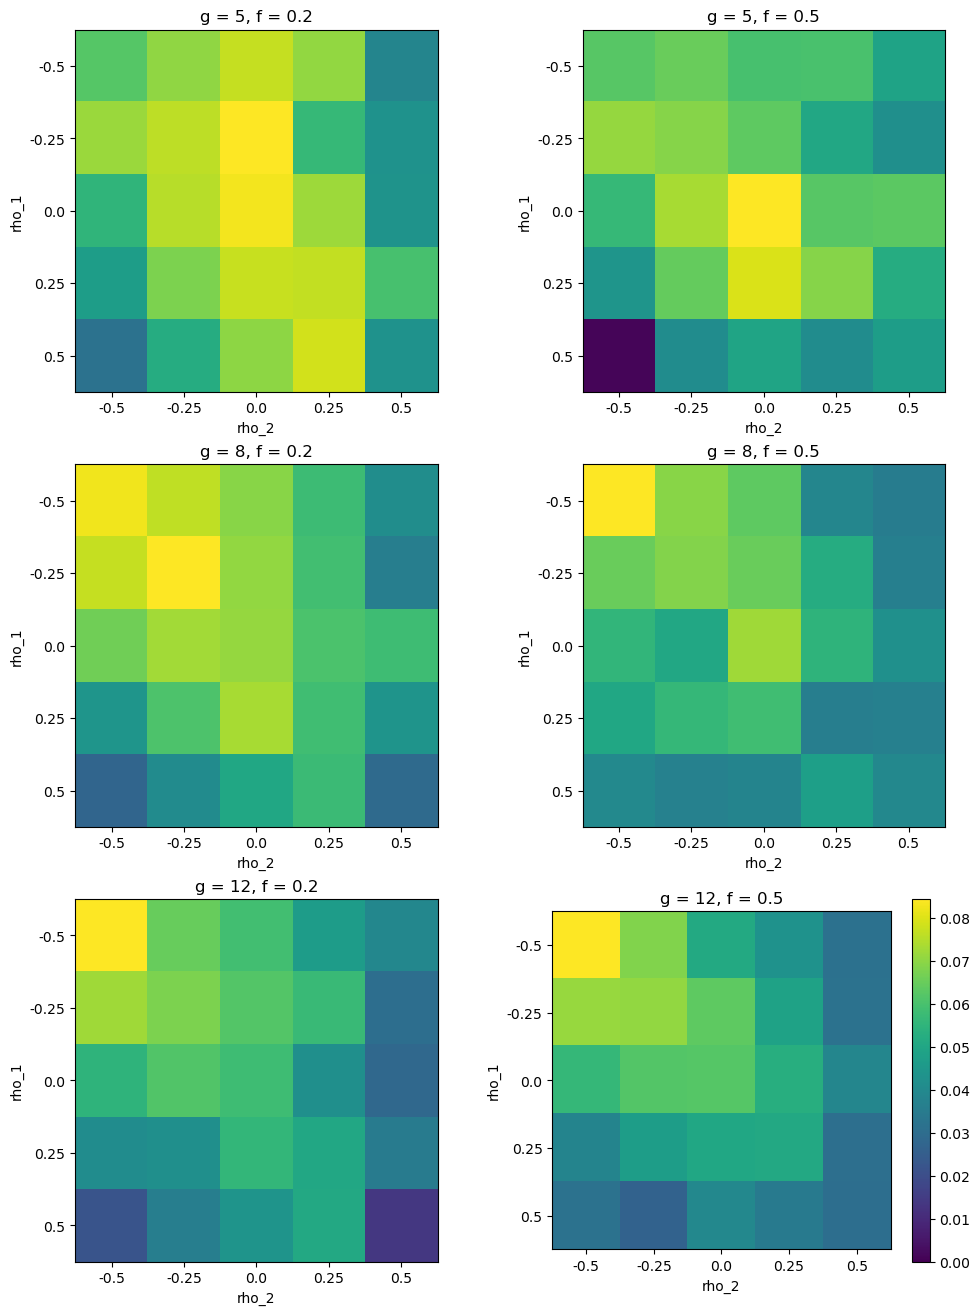

In [6]:
fig, ax = plt.subplots(3, 2, figsize=(12, 16))
for i in range(3):
    for j in range(2):
        im = ax[i,j].imshow(results_array[i, :,:,j,0,0], vmin=0)
        ax[i,j].set_xticks(list(range(5)), configs_array['rho_2'])
        ax[i,j].set_yticks(list(range(5)), configs_array['rho_1'])
        ax[i,j].set_ylabel('rho_1')
        ax[i,j].set_xlabel('rho_2')
        ax[i,j].set_title('g = {}, f = {}'.format(configs_array['g'][i], configs_array['f_transition'][j]))
fig.colorbar(im)

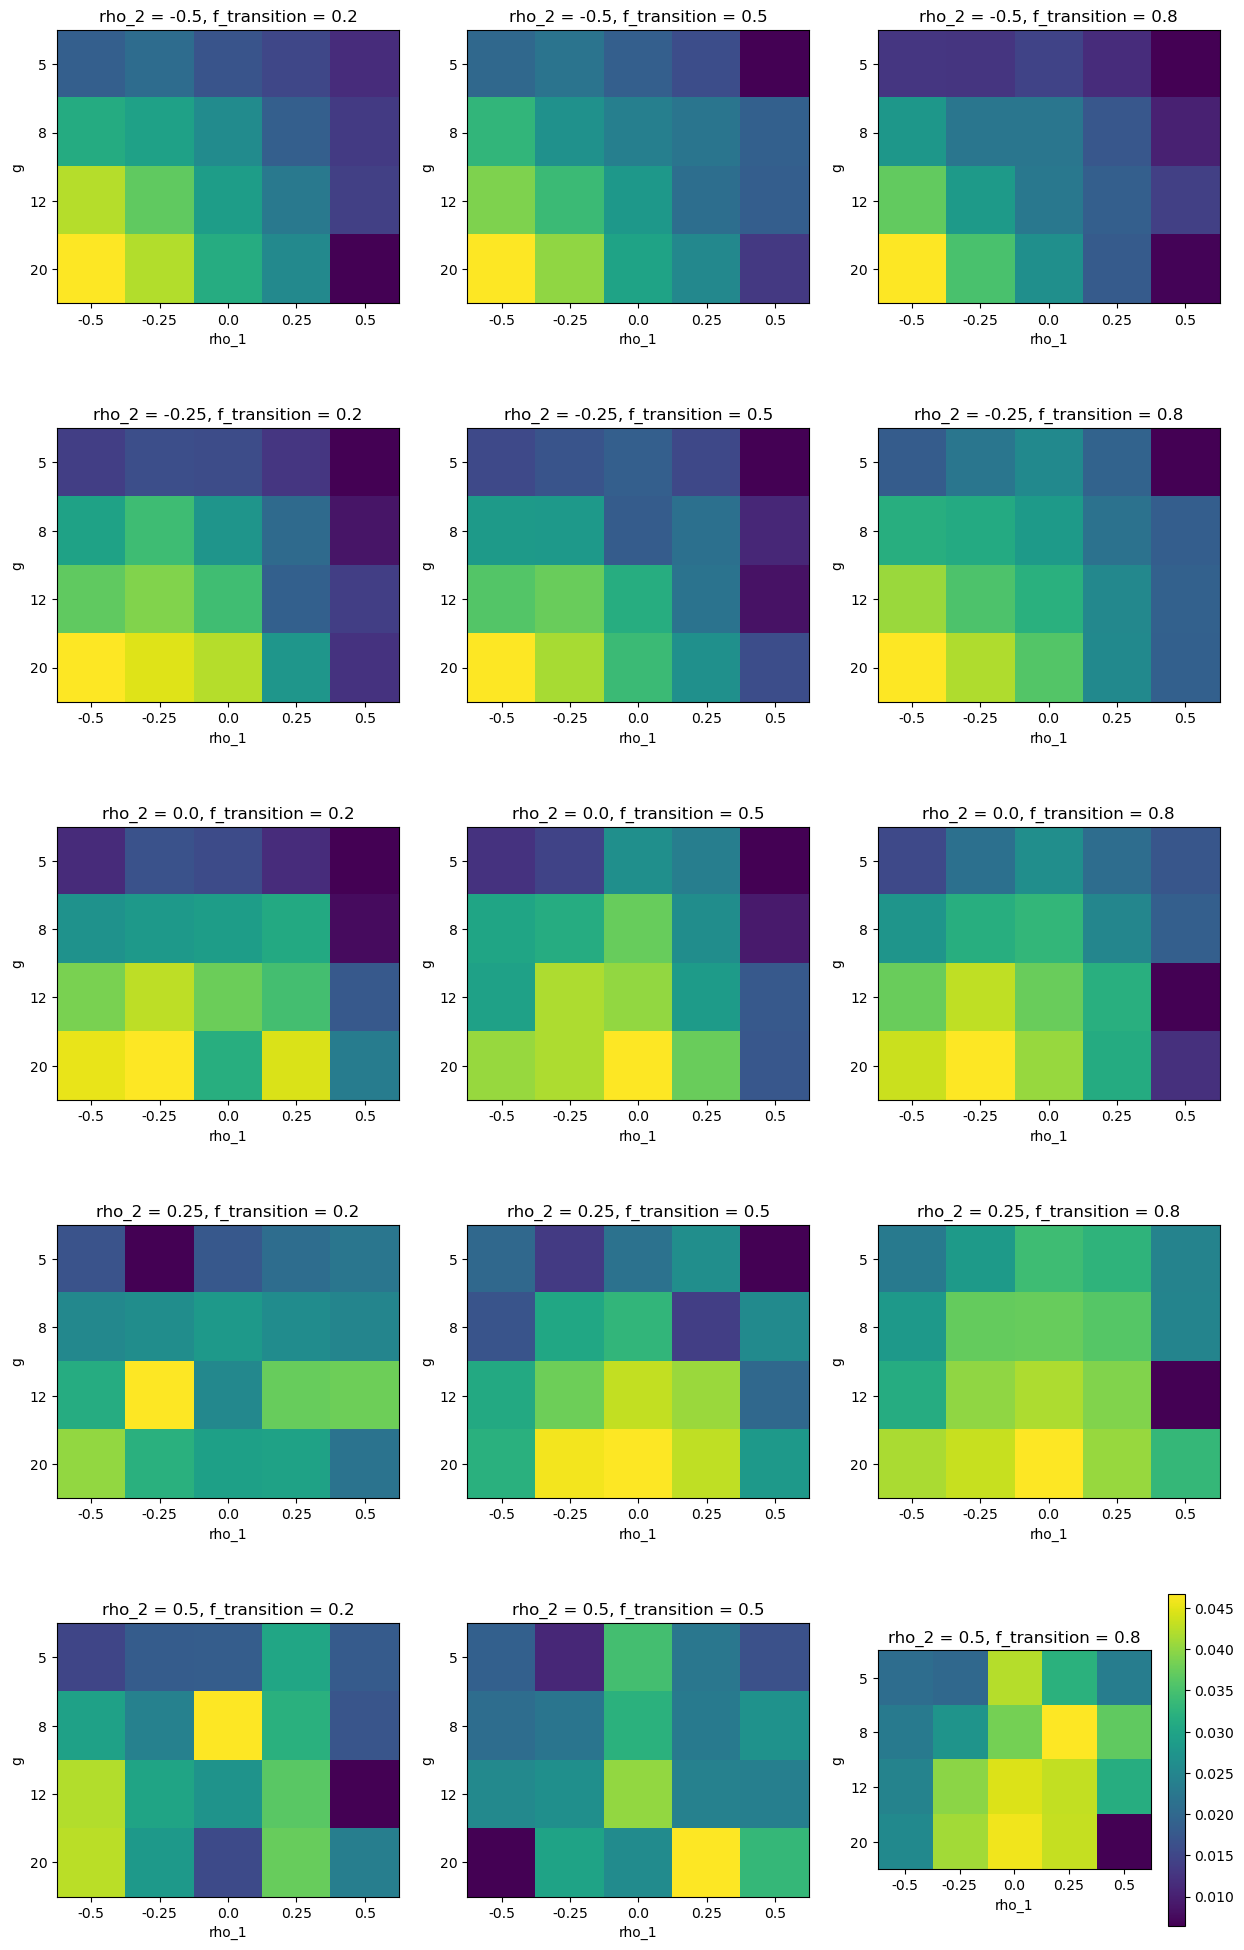

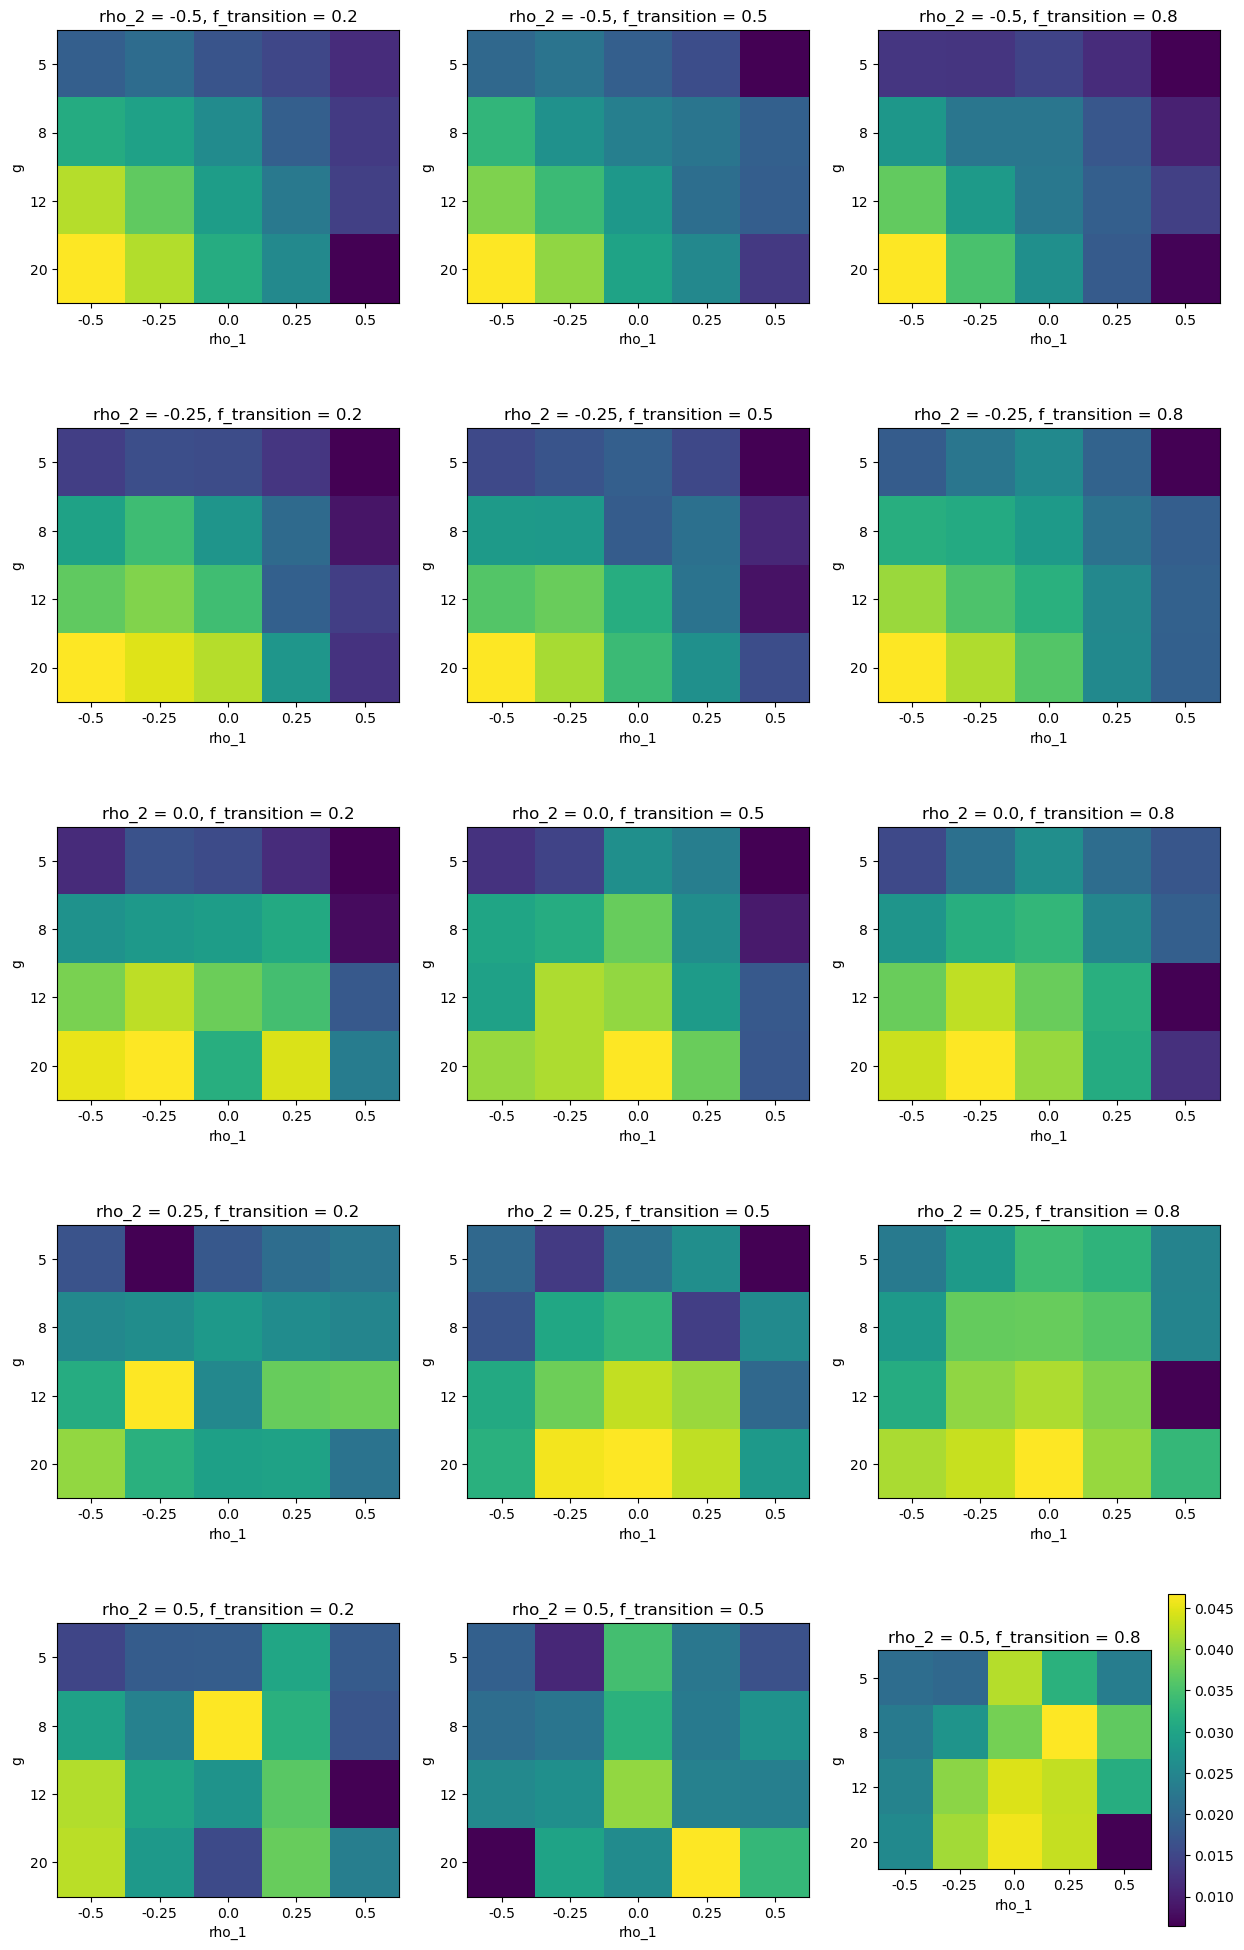

In [7]:
plot_3d_or_4d_array_of_config_results(configs_array, results_array[:,:,:,:,0], key_order)

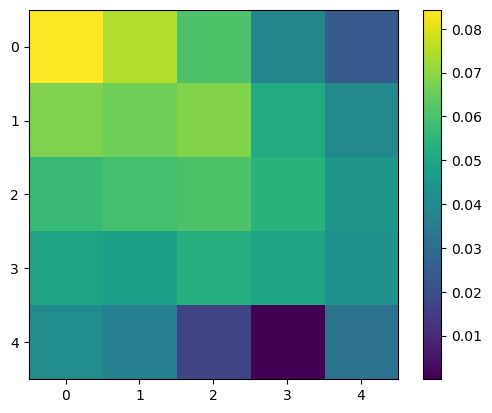

In [4]:
plt.imshow(results_array[2,:,:,2,0,0])
plt.colorbar()

In [5]:
configs_array

{'g': [5, 8, 12, 20],
 'rho_1': [-0.5, -0.25, 0.0, 0.25, 0.5],
 'rho_2': [-0.5, -0.25, 0.0, 0.25, 0.5],
 'f_transition': [0.2, 0.5, 0.8],
 'i_seed': [0]}

In [ ]:
#does spectrum of activity match shape of D when PR_D is small?
#double check shape invariance with N
#look at this fly activity data

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    lags = results_array[i,0,0]
    for k in range(10):
        ax[i].plot(lags, results_array[i,k,1], color='C0', alpha=0.3)
    ax[i].plot(lags, np.roll(results_array[i,k,2], -1), color='C1')
    ax[i].plot(lags, results_array[i,:,1].mean(0), color='C0')

In [ ]:
results_array.shape

In [ ]:
configs_array

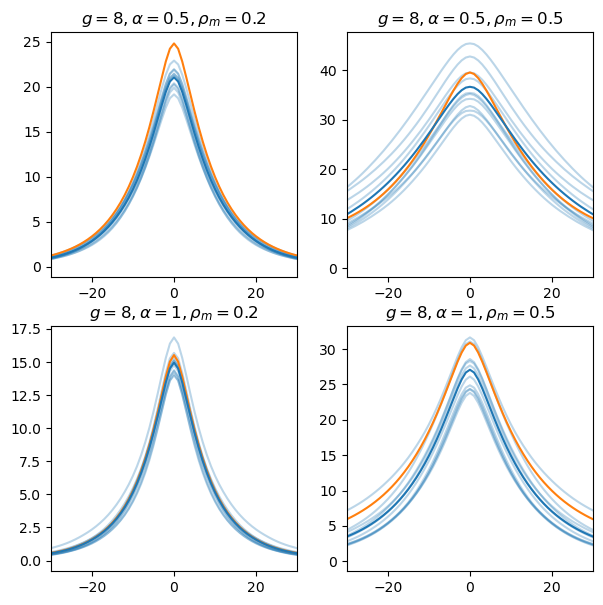

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
i_g = 0
for i in range(2):
    for j in range(2):
        lags = results_array[0,0,0,0,0]
        for k in range(10):
            ax[i,j].plot(lags, results_array[i_g,i,j,k,1], color='C0', alpha=0.3)
        ax[i,j].plot(lags, np.roll(results_array[i_g,i,j,k,2], -1), color='C1')
        ax[i,j].plot(lags, results_array[i_g,i,j,:,1].mean(0), color='C0')
        ax[i,j].set_title(r'$g = {}, \alpha = {}, \rho_m = {}$'.format(configs_array['g'][i_g],
                                                                          configs_array['alpha'][i%2],
                                                                          configs_array['max_rho'][j]))
        ax[i,j].set_xlim([-30, 30])
#fig.savefig('figs/LDR_sym_psi_fit_g={}_zoom.pdf'.format(configs_array['g'][i_g]))

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(9, 15))
for i in range(4):
    for j in range(2):
        lags = results_array[i//2,0,0,0,0]
        for k in range(10):
            ax[i,j].plot(lags, results_array[i//2,i%2,j,k,1], color='C0', alpha=0.3)
        ax[i,j].plot(lags, np.roll(results_array[i//2,i%2,j,k,2], -1), color='C1')
        ax[i,j].plot(lags, results_array[i//2,i%2,j,:,1].mean(0), color='C0')
        ax[i,j].set_title(r'$g = {}, \alpha = {}, \rho_m = {}$'.format(configs_array['g'][i//2],
                                                                          configs_array['alpha'][i%2],
                                                                          configs_array['max_rho'][j]))

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,0].mean(-1)
sem_pr = results_array[:,:,0].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,0],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['g'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['g'], results_array[:,0,1], color='k')
plt.ylim([0, 0.07])

In [ ]:
sem_pr.confidence_interval.low

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
#g_eff plot
i_alpha = 1
i_G = 1
mean_pr = results_array[:,i_alpha,i_G,:,0].mean(-1)
sem_pr = results_array[:,i_alpha,i_G,:,0].std(-1)/np.sqrt(10)
ax[0].errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
ax[0].plot(configs_array['g'], results_array[:,i_alpha,i_G,0,1], color='k')
ax[0].set_ylim([0, 0.1])

In [ ]:
plt.plot(results_array[:,:,:,:,0].flatten(), results_array[:,:,:,:,1].flatten(), '.')
x = np.arange(0, 0.15, 0.01)
plt.plot(x, x)
plt.xlim([0, 0.15])
plt.ylim([0, 0.15])

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(results_array[:,:,:,:,0].mean(-1).flatten(), results_array[:,:,:,:,1].mean(-1).flatten(), '.')
x = np.arange(0, 0.15, 0.01)
plt.plot(x, x)
plt.xlim([0, 0.15])
plt.ylim([0, 0.15])
plt.axis('equal')

In [ ]:
configs_array

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(8, 14))
for i in range(4):
    for j in range(3):
        ax[i,0].set_ylabel(r'$\alpha = {}$'.format(configs_array['alpha'][i]))
        ax[0,j].set_title(r'$PR_G = {}$'.format(configs_array['PR_G'][j]))
        if i !=0 or j!= 0:
            ax[i,j].set_xticks([])
        if j!=0:
            ax[i,j].set_yticks([])
        else:
            ax[i,j].set_yticks([0, 0.05, 0.1, 0.13])
        for k in range(10):
            ax[i,j].plot(configs_array['g'], results_array[:,i,j,k,0], '.', color='C0', alpha=0.2)
        ax[i,j].plot(configs_array['g'], results_array[:,i,j,0,1], color='k')
        ax[i,j].plot(configs_array['g'], results_array[:,i,j,:,0].mean(-1), color='C0', alpha=1)
        ax[i,j].set_ylim([0, 0.13])
ax[0,0].set_xlabel(r'$g_{eff}$')
ax[0,0].set_xticks(configs_array['g'])
#fig.savefig('figs/PR_phi_match.pdf')

In [ ]:
for i_g in range(3):
    fig, ax = plt.subplots(3, 2, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(3):
        for j in range(2):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(20):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags[1:], results_array[i_g,i,j,0,2,1:], color='C1')
    fig.savefig('figs/LDRG_theory_match_lowPR_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
for i_g in [0]:
    fig, ax = plt.subplots(5, 5, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(5):
        for j in range(5):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(5):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags[1:], results_array_1[2,i,j,0,1,1:], color='C1')
    #fig.savefig('figs/LDRG_theory_match_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
for i_g in range(5):
    fig, ax = plt.subplots(5, 5, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(5):
        for j in range(5):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(5):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags, results_array[i_g,i,j,0,2,:], color='C1')
    #fig.savefig('figs/LDRG_theory_match_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
fig, ax = plt.subplots(6, 1, figsize=(4, 12))
T_window = 100
dT = 0.05
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
lags = np.arange(0, T_window, dT)
n_lags = int(T_window/dT)
lags_full = np.concatenate([-lags[-n_lags:][::-1], lags[1:n_lags], np.array([lags[-1]])])
for i in range(6):
    
    #Choose g
    g = configs_array['g'][i]
    
    ### --- Compute single-unit properties
    d = compute_Delta_0(g=g)
    time, Delta_T = integrate_potential(d, g=g, tau_max=T_window, N_tau=int(T_window/dT))
    Delta_T = fix(Delta_T)
    C_Phi_half = compute_C_simple(d, Delta_T)
    alpha = compute_phi_prime_avg(d)
    
    ### --- Compute Psi from theory --- ###

    #Define relevant single-unit functions
    C_phi = np.concatenate([C_Phi_half[-n_lags:][::-1],
                            C_Phi_half[1:n_lags],
                            np.array([C_Phi_half[-1]])])
    C_phi_omega = fft(C_phi, dT)
    T = len(C_phi)
    t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
    sampfreq = 1/dT
    w = 2*np.pi*sampfreq*t_indices/T
    C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)
    S_phi = alpha/(np.sqrt(2*np.pi)*(1 + 1j*w))
    S_phi_S_phi = np.multiply.outer(S_phi, S_phi)

    #Compute psi for iid random network
    Psi_PRX = (1/(np.abs(1 - 2*np.pi*(g**2) * (S_phi_S_phi))**2) - 1)*C_phi_C_phi
    Psi_PRX_tau = ifft(Psi_PRX, dT)
    Psi_tau_tau = np.diag(Psi_PRX_tau)
    
    ### --- Double check with David's code --- ###
    Psi_tau_2 = compute_psi_theory(symmetrize(Delta_T), g, dT)
    Ptt2 = np.diag(Psi_tau_2)
    Psi_tau_tau_2 = np.concatenate([Ptt2[-len(Ptt2)//2:], Ptt2[:len(Ptt2)//2]])

    for j in range(5):
        ax[i].plot(results_array[i,j,0,:],
                   results_array[i,j,1,:], color='C0', alpha=0.1)
    
    ax[i].plot(results_array[i,j,0,:],
               results_array[i,:,1,:].mean(0), color='C0', alpha=1)
    ax[i].plot(lags_full, Psi_tau_tau, color='C1')
    ax[i].plot(lags_full, Psi_tau_tau_2, color='C2')
    ax[i].set_ylim([0, 14])